# Airbnb Capstone Project

## 1.Import all Libraries

In [1]:
### import all libraries and set settings 
import pandas as pd
import numpy as np
import geopandas as gpd

import requests
import json
import gzip
import pyproj
import math

from py_functions import increase_bbox 
from sklearn.neighbors import BallTree
from scipy.spatial import cKDTree
from shapely.geometry import Point
from shapely.ops import transform
from functools import partial

pd.set_option('display.max_columns', None) # show all columns  

## 2.Inside Airbnb pipeline

In [2]:
### Define path, .gz archive file name, country and city for url
path ='data/'
gz_file = "listings.csv.gz"
country = "united-kingdom"
state = "england"
city = "london"
url = f"http://data.insideairbnb.com/{country}/{state}/{city}/2023-03-14/data/{gz_file}"

In [3]:
### Create new directory for city
!mkdir {path}{city}

mkdir: data/london: File exists


In [4]:
### Download the .gz file
r = requests.get(url)
with open(path+city+'/'+gz_file, 'wb') as f:
    f.write(r.content)

In [5]:
### Unzip the .gz file and save the content as pd.DataFrame via read_csv
with gzip.open(path+city+'/'+gz_file) as f:
    listings = pd.read_csv(f)


In [6]:
### select only desired columns 
columns_keeper = (["id",
                   "listing_url",
                   "name",
                   "picture_url",
                   "host_id",
                   "host_response_rate",
                   "host_acceptance_rate",
                   "host_is_superhost",
                   "host_listings_count",
                   "host_total_listings_count",
                   "neighbourhood_cleansed",
                   "latitude",
                   "longitude",
                   "room_type",
                   "accommodates",
                   "bathrooms_text",
                   "bedrooms",
                   "beds",
                   "amenities",
                   "price",
                   "minimum_nights",
                   "maximum_nights",
                   "instant_bookable",
                   "number_of_reviews",
                   "number_of_reviews_ltm",
                   "number_of_reviews_l30d",
                   "first_review",
                   "last_review",
                   "review_scores_rating",
                   "review_scores_accuracy",
                   "review_scores_cleanliness",
                   "review_scores_checkin",
                   "review_scores_communication",
                   "review_scores_location",
                   "review_scores_value",
                   "reviews_per_month"]
                  )

In [7]:
### filter columns 
listings_short = listings[columns_keeper]

### 2.2.First Look - Airbnb Data

In [8]:
listings_short.head()

,id,listing_url,name,picture_url,host_id,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,neighbourhood_cleansed,latitude,longitude,room_type,accommodates,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,instant_bookable,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month
0,714569379355913481,https://www.airbnb.com/rooms/714569379355913481,Lovely private bedroom in Muswell Hill.,https://a0.muscache.com/pictures/miso/Hosting-...,39009854,NaN,NaN,f,1.0,1.0,Haringey,51.597280,-0.139330,Private room,1,1 shared bath,1.0,1.0,"[""Iron"", ""Hangers"", ""Hair dryer"", ""Outdoor din...",$100.00,1,365,f,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,808038970516277767,https://www.airbnb.com/rooms/808038970516277767,Studio Flat Franklin London,https://a0.muscache.com/pictures/miso/Hosting-...,495977998,100%,100%,f,14.0,31.0,Barnet,51.636518,-0.177475,Entire home/apt,1,1 bath,1.0,1.0,[],$65.00,180,365,t,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,822557738577472503,https://www.airbnb.com/rooms/822557738577472503,PropertyPlug - 2Bed Flat in Edgware SmartTV WiFi,https://a0.muscache.com/pictures/d77957d5-695a...,325629338,100%,91%,t,4.0,8.0,Harrow,51.608180,-0.277400,Entire home/apt,4,2 baths,2.0,2.0,"[""Dining table"", ""Washer"", ""Outdoor furniture""...",$132.00,2,28,t,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3518856,https://www.airbnb.com/rooms/3518856,Wimbledon Double Bedroom Ensuite,https://a0.muscache.com/pictures/23a18442-fc1d...,187811,NaN,100%,f,2.0,5.0,Merton,51.422310,-0.188410,Private room,1,1 private bath,1.0,1.0,"[""Washer"", ""Iron"", ""Hangers"", ""Kitchen"", ""Smok...",$100.00,5,1125,f,4,0,0,2015-12-27,2016-07-11,3.67,3.0,4.33,4.67,5.0,3.67,3.67,0.05
4,4876550,https://www.airbnb.com/rooms/4876550,Stunning Apartment 2 minutes walk to Tube Station,https://a0.muscache.com/pictures/miso/Hosting-...,25087384,75%,46%,f,1.0,1.0,Barnet,51.602282,-0.193606,Entire home/apt,2,1 bath,1.0,1.0,"[""First aid kit"", ""Washer"", ""Fire extinguisher...",$120.00,5,90,f,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
listings_short.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75241 entries, 0 to 75240
Data columns (total 36 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           75241 non-null  int64  
 1   listing_url                  75241 non-null  object 
 2   name                         75210 non-null  object 
 3   picture_url                  75241 non-null  object 
 4   host_id                      75241 non-null  int64  
 5   host_response_rate           46285 non-null  object 
 6   host_acceptance_rate         51028 non-null  object 
 7   host_is_superhost            75223 non-null  object 
 8   host_listings_count          75236 non-null  float64
 9   host_total_listings_count    75236 non-null  float64
 10  neighbourhood_cleansed       75241 non-null  object 
 11  latitude                     75241 non-null  float64
 12  longitude                    75241 non-null  float64
 13  room_type       

In [10]:
listings_short.describe()

,id,host_id,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bedrooms,beds,minimum_nights,maximum_nights,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month
count,7.524100e+04,7.524100e+04,75236.000000,75236.000000,75241.000000,75241.000000,75241.000000,71768.000000,74135.000000,75241.000000,7.524100e+04,75241.000000,75241.000000,75241.000000,56548.000000,55595.000000,55606.000000,55564.000000,55592.000000,55565.000000,55562.000000,56548.000000
mean,2.368628e+17,1.390765e+08,39.525958,71.379100,51.509708,-0.128108,3.105793,1.513153,1.772833,5.750748,7.790300e+03,17.974668,5.736301,0.456467,4.588159,4.723349,4.623915,4.783393,4.801027,4.729358,4.607755,0.877064
std,3.425911e+17,1.529621e+08,222.170789,420.039233,0.048369,0.099341,1.936972,0.885015,1.228013,24.240947,1.914055e+06,41.984021,12.991805,1.277612,0.779083,0.489328,0.550721,0.453835,0.448759,0.418873,0.521839,1.234003
min,1.391300e+04,2.594000e+03,1.000000,1.000000,51.295937,-0.497800,0.000000,1.000000,1.000000,1.000000,1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000
25%,1.981740e+07,1.995923e+07,1.000000,1.000000,51.483540,-0.189390,2.000000,1.000000,1.000000,1.000000,4.200000e+01,1.000000,0.000000,0.000000,4.500000,4.670000,4.500000,4.750000,4.790000,4.640000,4.500000,0.130000
50%,3.933875e+07,6.745519e+07,2.000000,2.000000,51.513840,-0.126280,2.000000,1.000000,1.000000,2.000000,3.650000e+02,4.000000,0.000000,0.000000,4.820000,4.890000,4.800000,4.940000,4.970000,4.850000,4.750000,0.450000
75%,6.562985e+17,2.248670e+08,5.000000,8.000000,51.539450,-0.068460,4.000000,2.000000,2.000000,4.000000,1.125000e+03,17.000000,6.000000,0.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,4.970000,1.090000
max,8.463271e+17,5.050400e+08,2138.000000,24047.000000,51.681142,0.288570,16.000000,22.000000,38.000000,1125.000000,5.248556e+08,1328.000000,564.000000,68.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,51.050000


## 2.3. Clean Airbnb 

### 2.3.1. Handling Missing Data 

In [11]:
listings_short.shape

(75241, 36)

In [12]:
listings_short.isnull().sum()

id                                 0
listing_url                        0
name                              31
picture_url                        0
host_id                            0
host_response_rate             28956
host_acceptance_rate           24213
host_is_superhost                 18
host_listings_count                5
host_total_listings_count          5
neighbourhood_cleansed             0
latitude                           0
longitude                          0
room_type                          0
accommodates                       0
bathrooms_text                   124
bedrooms                        3473
beds                            1106
amenities                          0
price                              0
minimum_nights                     0
maximum_nights                     0
instant_bookable                   0
number_of_reviews                  0
number_of_reviews_ltm              0
number_of_reviews_l30d             0
first_review                   18693
l

**host_is_superhost**

In [13]:
# check the different values of "host_is_superhost"
listings_short["host_is_superhost"].value_counts(dropna=False)

f      64574
t      10649
NaN       18
Name: host_is_superhost, dtype: int64

In [14]:
# check how many listings the hosts with nan value for "host_is_superhost" have: 
listings_short[listings_short['host_is_superhost'].isna()]["host_total_listings_count"].value_counts()

5.0     4
2.0     3
6.0     2
10.0    2
7.0     2
4.0     2
26.0    2
1.0     1
Name: host_total_listings_count, dtype: int64

In [15]:
# we can fill values with "f" for false 
listings_short["host_is_superhost"] = listings_short["host_is_superhost"].fillna("f")

/var/folders/5_/7xzpd6d945j4_28t7806tw4h0000gn/T/ipykernel_10012/3651527053.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  listings_short["host_is_superhost"] = listings_short["host_is_superhost"].fillna("f")


In [16]:
# renaming Rows with NaN to "Unknown"
listings_short[["name", "host_response_rate",
                "host_acceptance_rate"]] = listings_short[["name", "host_response_rate",
                                                           "host_acceptance_rate"]].fillna("Unknown")


/var/folders/5_/7xzpd6d945j4_28t7806tw4h0000gn/T/ipykernel_10012/3052865995.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  listings_short[["name", "host_response_rate",


**host_listings_count & host_total_listings_count**

In [17]:
# set the mode for host_listings_count & host_total_listings_count
listings_short["host_listings_count"].fillna(listings_short["host_listings_count"].mode()[0], inplace=True)

listings_short["host_total_listings_count"].fillna(listings_short["host_total_listings_count"].mode()[0], inplace=True)

/var/folders/5_/7xzpd6d945j4_28t7806tw4h0000gn/T/ipykernel_10012/859434433.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  listings_short["host_listings_count"].fillna(listings_short["host_listings_count"].mode()[0], inplace=True)
/var/folders/5_/7xzpd6d945j4_28t7806tw4h0000gn/T/ipykernel_10012/859434433.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  listings_short["host_total_listings_count"].fillna(listings_short["host_total_listings_count"].mode()[0], inplace=True)


**bedrooms , beds & bathrooms_text**

In [18]:
# set the mode for above columns
listings_short["bathrooms_text"].fillna(listings_short["bathrooms_text"].mode()[0], inplace=True)

listings_short["bedrooms"].fillna(listings_short["bedrooms"].mode()[0], inplace=True)

listings_short["beds"].fillna(listings_short["beds"].mode()[0], inplace=True)

/var/folders/5_/7xzpd6d945j4_28t7806tw4h0000gn/T/ipykernel_10012/1250815054.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  listings_short["bathrooms_text"].fillna(listings_short["bathrooms_text"].mode()[0], inplace=True)
/var/folders/5_/7xzpd6d945j4_28t7806tw4h0000gn/T/ipykernel_10012/1250815054.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  listings_short["bedrooms"].fillna(listings_short["bedrooms"].mode()[0], inplace=True)
/var/folders/5_/7xzpd6d945j4_28t7806tw4h0000gn/T/ipykernel_10012/1250815054.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the cave

**Convert host_response_rate & host_acceptance_rate**

In [19]:
## Convert response rate/acceptance rate from % in integer
listings_short["host_acceptance_rate_int"] = listings_short["host_acceptance_rate"].str[:-1]
listings_short["host_acceptance_rate_int"] = listings_short["host_acceptance_rate_int"].replace('Unknow', np.nan)
listings_short["host_acceptance_rate_int"] = listings_short["host_acceptance_rate_int"].astype("float64")
listings_short["host_acceptance_rate"] = listings_short["host_acceptance_rate_int"]
listings_short.drop("host_acceptance_rate_int", axis=1, inplace = True)

/var/folders/5_/7xzpd6d945j4_28t7806tw4h0000gn/T/ipykernel_10012/4137212484.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  listings_short["host_acceptance_rate_int"] = listings_short["host_acceptance_rate"].str[:-1]
/var/folders/5_/7xzpd6d945j4_28t7806tw4h0000gn/T/ipykernel_10012/4137212484.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  listings_short["host_acceptance_rate_int"] = listings_short["host_acceptance_rate_int"].replace('Unknow', np.nan)
/var/folders/5_/7xzpd6d945j4_28t7806tw4h0000gn/T/

In [20]:
#same for host_acceptance_rate 

listings_short["host_response_rate_int"] = listings_short["host_response_rate"].str[:-1]
listings_short["host_response_rate_int"] = listings_short["host_response_rate_int"].replace('Unknow', np.nan)
listings_short["host_response_rate"] = listings_short["host_response_rate_int"].astype("float64")
listings_short.drop("host_response_rate_int", axis=1, inplace = True)

/var/folders/5_/7xzpd6d945j4_28t7806tw4h0000gn/T/ipykernel_10012/3075004784.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  listings_short["host_response_rate_int"] = listings_short["host_response_rate"].str[:-1]
/var/folders/5_/7xzpd6d945j4_28t7806tw4h0000gn/T/ipykernel_10012/3075004784.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  listings_short["host_response_rate_int"] = listings_short["host_response_rate_int"].replace('Unknow', np.nan)
/var/folders/5_/7xzpd6d945j4_28t7806tw4h0000gn/T/ipykerne

**price**

In [21]:
#convert Price in Integer

listings_short["price"] = listings_short["price"].str[1:]
listings_short["price"] = listings_short["price"].str.replace(",", "")
listings_short["price"] = listings_short["price"].astype("float64")

/var/folders/5_/7xzpd6d945j4_28t7806tw4h0000gn/T/ipykernel_10012/4083807180.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  listings_short["price"] = listings_short["price"].str[1:]
/var/folders/5_/7xzpd6d945j4_28t7806tw4h0000gn/T/ipykernel_10012/4083807180.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  listings_short["price"] = listings_short["price"].str.replace(",", "")
/var/folders/5_/7xzpd6d945j4_28t7806tw4h0000gn/T/ipykernel_10012/4083807180.py:5: SettingWithCopyWarning: 
A value is trying to

**Bathroom_text & private_bath**

In [22]:
#convert bathroom text top bool ('private_bath)
listings_short['private_bath'] = ~listings_short['bathrooms_text'].str.contains('shared|Shared')
listings_short.drop('bathrooms_text', inplace = True, axis = 1)

/var/folders/5_/7xzpd6d945j4_28t7806tw4h0000gn/T/ipykernel_10012/2776869170.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  listings_short['private_bath'] = ~listings_short['bathrooms_text'].str.contains('shared|Shared')
/var/folders/5_/7xzpd6d945j4_28t7806tw4h0000gn/T/ipykernel_10012/2776869170.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  listings_short.drop('bathrooms_text', inplace = True, axis = 1)


In [23]:
listings_short.head(2)

,id,listing_url,name,picture_url,host_id,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,neighbourhood_cleansed,latitude,longitude,room_type,accommodates,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,instant_bookable,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,private_bath
0,714569379355913481,https://www.airbnb.com/rooms/714569379355913481,Lovely private bedroom in Muswell Hill.,https://a0.muscache.com/pictures/miso/Hosting-...,39009854,NaN,NaN,f,1.0,1.0,Haringey,51.597280,-0.139330,Private room,1,1.0,1.0,"[""Iron"", ""Hangers"", ""Hair dryer"", ""Outdoor din...",100.0,1,365,f,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,808038970516277767,https://www.airbnb.com/rooms/808038970516277767,Studio Flat Franklin London,https://a0.muscache.com/pictures/miso/Hosting-...,495977998,100.0,100.0,f,14.0,31.0,Barnet,51.636518,-0.177475,Entire home/apt,1,1.0,1.0,[],65.0,180,365,t,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


**room_type**

In [24]:
#renaming the values 
listings_short["room_type"] = listings_short["room_type"].str.replace("Entire home/apt", "Entire home")

/var/folders/5_/7xzpd6d945j4_28t7806tw4h0000gn/T/ipykernel_10012/1045346324.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  listings_short["room_type"] = listings_short["room_type"].str.replace("Entire home/apt", "Entire home")


**Instant_bookable and Host_is_superhost as bool**

In [25]:
listings_short['instant_bookable'] = listings_short['instant_bookable'].map({'f': False, 't': True})
listings_short['host_is_superhost'] = listings_short['host_is_superhost'].map({'f': False, 't': True})

/var/folders/5_/7xzpd6d945j4_28t7806tw4h0000gn/T/ipykernel_10012/831478609.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  listings_short['instant_bookable'] = listings_short['instant_bookable'].map({'f': False, 't': True})
/var/folders/5_/7xzpd6d945j4_28t7806tw4h0000gn/T/ipykernel_10012/831478609.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  listings_short['host_is_superhost'] = listings_short['host_is_superhost'].map({'f': False, 't': True})


**amenities**

In [26]:
test = listings_short.copy()

In [27]:
# convert items in "amenities" to a list
test["amenities"] = test["amenities"].str.lower().str.replace('[','').str.replace(']','').str.replace('"','').str.replace(' ','_').str.split(',')


/var/folders/5_/7xzpd6d945j4_28t7806tw4h0000gn/T/ipykernel_10012/1066789727.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  test["amenities"] = test["amenities"].str.lower().str.replace('[','').str.replace(']','').str.replace('"','').str.replace(' ','_').str.split(',')


In [28]:
# create new columns for each amenity 
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
amenities = test.join(pd.DataFrame(mlb.fit_transform(test.pop('amenities')),
                          columns=mlb.classes_,
                          index=test.index))

In [29]:
# create a list of amenity with fewer than 10% of listings
infrequent_amenities = []
for col in amenities.iloc[: , 35:].columns:
    if amenities[col].sum() < len(amenities)/10:
        infrequent_amenities.append(col)

# drop infrequent amenity features
amenities.drop(infrequent_amenities, axis=1, inplace=True)


In [30]:
# combine _coffee & _coffe_maker to one column
amenities['_coffee_'] = (amenities['_coffee_maker'] | amenities['_coffee']).astype(int)


In [31]:
# focus on relevant columns
amenity_keeper = ["id",
                  "_wifi",
                  "_long_term_stays_allowed",
                  "_private_patio_or_balcony",
                  "_private_entrance",
                  "_pets_allowed",
                  "_outdoor_dining_area",
                  "_lockbox",
                  "_kitchen",
                  "_hair_dryer",
                  "_free_street_parking",
                  "_free_parking_on_premises",
                  "_dedicated_workspace",
                  "_coffee_maker",
                  "_coffee",
                  "_bed_linens",
                  "_bathtub"]


In [32]:
# keep only relevant columns 
amenities_short = amenities[amenity_keeper]

In [33]:
# get rid of first "_"
amenities_short.columns = amenities_short.columns.str.replace('_','', 1)


In [34]:
# merge to one dataframe 
airbnb = listings_short.merge(amenities_short, how="left", on="id")

In [65]:
airbnb.shape

(75241, 52)

## 3.Overpass Pipeline

### 3.1. Get the Data 

In [36]:
### Increase outside border of listings
london_bbox = increase_bbox(listings)

In [37]:
# Increasing the maxs by 0.01 and decreasing the mins by 0.01 
# will shift the outline's border by a bit more than 1km in each direction.

# See increase_bbox function in py_functions.py

In [38]:
# (northern hemisphere)
# latitude max = north
# latitude min = south
# longitude max = east
# longitude min = west

In [39]:
# ### Get OSM data for slightly bigger bbox
# overpass_url = "http://overpass-api.de/api/interpreter"
# overpass_query = f"""
# [out:json];
# (
#     node["amenity"="restaurant"]({london_bbox["south_shifted"]},{london_bbox["west_shifted"]},{london_bbox["north_shifted"]},{london_bbox["east_shifted"]});
#     way["amenity"="restaurant"]({london_bbox["south_shifted"]},{london_bbox["west_shifted"]},{london_bbox["north_shifted"]},{london_bbox["east_shifted"]});
#     node["amenity"="bar"]({london_bbox["south_shifted"]},{london_bbox["west_shifted"]},{london_bbox["north_shifted"]},{london_bbox["east_shifted"]});
#     node["amenity"="pub"]({london_bbox["south_shifted"]},{london_bbox["west_shifted"]},{london_bbox["north_shifted"]},{london_bbox["east_shifted"]});
#     );
#     (._;>;);
# out center;
# """
# response = requests.get(overpass_url,
#                         params={'data': overpass_query})
# data = response.json()

# osm = pd.json_normalize(data, record_path="elements")


In [40]:
### Get OSM data for slightly bigger bbox
overpass_url = "http://overpass-api.de/api/interpreter"
overpass_query = f"""
[out:json];
(
    node["amenity"="bar"]({london_bbox["south_shifted"]},{london_bbox["west_shifted"]},{london_bbox["north_shifted"]},{london_bbox["east_shifted"]});
    node["amenity"="pub"]({london_bbox["south_shifted"]},{london_bbox["west_shifted"]},{london_bbox["north_shifted"]},{london_bbox["east_shifted"]});
    node["amenity"="restaurant"]({london_bbox["south_shifted"]},{london_bbox["west_shifted"]},{london_bbox["north_shifted"]},{london_bbox["east_shifted"]});
    node["amenity"="cafe"]({london_bbox["south_shifted"]},{london_bbox["west_shifted"]},{london_bbox["north_shifted"]},{london_bbox["east_shifted"]});
    node["amenity"="fast_food"]({london_bbox["south_shifted"]},{london_bbox["west_shifted"]},{london_bbox["north_shifted"]},{london_bbox["east_shifted"]});
    node["railway"="subway_entrance"]({london_bbox["south_shifted"]},{london_bbox["west_shifted"]},{london_bbox["north_shifted"]},{london_bbox["east_shifted"]});
    node["cuisine"]({london_bbox["south_shifted"]},{london_bbox["west_shifted"]},{london_bbox["north_shifted"]},{london_bbox["east_shifted"]});
    way["amenity"="bar"]({london_bbox["south_shifted"]},{london_bbox["west_shifted"]},{london_bbox["north_shifted"]},{london_bbox["east_shifted"]});
    way["amenity"="pub"]({london_bbox["south_shifted"]},{london_bbox["west_shifted"]},{london_bbox["north_shifted"]},{london_bbox["east_shifted"]});
    way["amenity"="restaurant"]({london_bbox["south_shifted"]},{london_bbox["west_shifted"]},{london_bbox["north_shifted"]},{london_bbox["east_shifted"]});
    way["amenity"="cafe"]({london_bbox["south_shifted"]},{london_bbox["west_shifted"]},{london_bbox["north_shifted"]},{london_bbox["east_shifted"]});
    way["amenity"="fast_food"]({london_bbox["south_shifted"]},{london_bbox["west_shifted"]},{london_bbox["north_shifted"]},{london_bbox["east_shifted"]});
    way["railway"="subway_entrance"]({london_bbox["south_shifted"]},{london_bbox["west_shifted"]},{london_bbox["north_shifted"]},{london_bbox["east_shifted"]});
    way["cuisine"]({london_bbox["south_shifted"]},{london_bbox["west_shifted"]},{london_bbox["north_shifted"]},{london_bbox["east_shifted"]});

    );
    (._;>;);
out center;
"""
response = requests.get(overpass_url,
                        params={'data': overpass_query})
data = response.json()

osm = pd.json_normalize(data, record_path="elements")


In [41]:
osm.shape

(87024, 735)

### 3.2. Data Cleaning OSM

In [42]:
### clean column names 
osm.columns = osm.columns.str.replace(".", "_", regex=False)
osm.columns = osm.columns.str.replace(":", "_", regex=False)


In [43]:
### drop all columns with no lat or lon values 
osm["lat"] = np.where(osm["lat"].isna(), osm["center_lat"], osm['lat'])
osm["lon"] = np.where(osm["lon"].isna(), osm["center_lon"], osm['lon'])

In [44]:
### rename lat/lon to latitude/longitude 
osm = osm.rename(columns={"lat": "latitude", "lon": "longitude"})


In [45]:
### drop "tags_" in the column names 
osm.columns = osm.columns.str.replace('tags_' , '')

In [46]:
### select only desired columns
osm_keepers = ["id",
                     "latitude",
                     "longitude",
                     "name",
                     "amenity",
                     "cuisine",
                     "diet_vegetarian",
                     "diet_vegan",
                     "railway"]

### 3.3. Data Cleaning OSM_SHORT

In [47]:
osm_short = osm[osm_keepers]

In [48]:
### drop all rows with no lat/lon
osm_short = osm_short.dropna(subset=['latitude'])


In [49]:
osm_short = osm_short.drop(osm_short[(osm_short['name'].isna()) & (osm_short['amenity'].isna())].index)

In [50]:
osm_short['amenity'] = osm_short['amenity'].str.replace('pub', 'bar')

In [51]:
osm_short['gastronomy'] = np.where(osm_short['amenity'].isin(['restaurant', 'fast_food']), True, False)

In [52]:
osm_short = osm_short[osm_short['amenity'].isin(['bar', 'restaurant', np.nan, 'cafe', 'fast_food', 'bakery', 'food_court'])]

In [53]:
osm_short['diet_vegetarian'] = np.where(osm_short['diet_vegetarian'].isin(['yes', 'only', 'limited']), True, osm_short['diet_vegetarian'])
osm_short['diet_vegetarian'] = np.where(osm_short['diet_vegetarian'] == 'no', False, osm_short['diet_vegetarian'])
osm_short['diet_vegan'] = np.where(osm_short['diet_vegan'].isin(['yes', 'only', 'limited']), True, osm_short['diet_vegan'])
osm_short['diet_vegan'] = np.where(osm_short['diet_vegan'] == 'no', False, osm_short['diet_vegan'])

In [54]:
osm_short.head()

,id,latitude,longitude,name,amenity,cuisine,diet_vegetarian,diet_vegan,railway,gastronomy
0,451152,51.600840,-0.194608,King of Prussia,bar,pizza;burger,True,True,NaN,False
1,451153,51.602031,-0.193503,Central Restaurant,restaurant,NaN,NaN,NaN,NaN,True
2,451154,51.599579,-0.196028,The Catcher in the Rye,bar,NaN,NaN,NaN,NaN,False
3,451271,51.614104,-0.176556,The Tally Ho,bar,NaN,NaN,NaN,NaN,False
4,12242503,51.592016,0.027962,Railway Bell,bar,NaN,NaN,NaN,NaN,False


In [55]:
osm_short.shape

(25614, 10)

## 4.Number of Amenities in 100/250/500 Meter

this has been calculated in Tableau and will now be merged into `airbnb` Dataframe

In [86]:
airbnb.head()

,id,listing_url,name,picture_url,host_id,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,neighbourhood_cleansed,latitude,longitude,room_type,accommodates,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,instant_bookable,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,private_bath,wifi,long_term_stays_allowed,private_patio_or_balcony,private_entrance,pets_allowed,outdoor_dining_area,lockbox,kitchen,hair_dryer,free_street_parking,free_parking_on_premises,dedicated_workspace,coffee_maker,coffee,bed_linens,bathtub,price_normalized
0,714569379355913481,https://www.airbnb.com/rooms/714569379355913481,Lovely private bedroom in Muswell Hill.,https://a0.muscache.com/pictures/miso/Hosting-...,39009854,NaN,NaN,False,1.0,1.0,Haringey,51.597280,-0.139330,Private room,1,1.0,1.0,"[""Iron"", ""Hangers"", ""Hair dryer"", ""Outdoor din...",100.0,1,365,False,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,-0.155397
1,808038970516277767,https://www.airbnb.com/rooms/808038970516277767,Studio Flat Franklin London,https://a0.muscache.com/pictures/miso/Hosting-...,495977998,100.0,100.0,False,14.0,31.0,Barnet,51.636518,-0.177475,Entire home,1,1.0,1.0,[],65.0,180,365,True,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.227212
2,822557738577472503,https://www.airbnb.com/rooms/822557738577472503,PropertyPlug - 2Bed Flat in Edgware SmartTV WiFi,https://a0.muscache.com/pictures/d77957d5-695a...,325629338,100.0,91.0,True,4.0,8.0,Harrow,51.608180,-0.277400,Entire home,4,2.0,2.0,"[""Dining table"", ""Washer"", ""Outdoor furniture""...",132.0,2,28,True,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,1,1,1,0,0,0,0,1,1,0,1,0,0,0,1,1,-0.089737
3,3518856,https://www.airbnb.com/rooms/3518856,Wimbledon Double Bedroom Ensuite,https://a0.muscache.com/pictures/23a18442-fc1d...,187811,NaN,100.0,False,2.0,5.0,Merton,51.422310,-0.188410,Private room,1,1.0,1.0,"[""Washer"", ""Iron"", ""Hangers"", ""Kitchen"", ""Smok...",100.0,5,1125,False,4,0,0,2015-12-27,2016-07-11,3.67,3.0,4.33,4.67,5.0,3.67,3.67,0.05,True,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,-0.155397
4,4876550,https://www.airbnb.com/rooms/4876550,Stunning Apartment 2 minutes walk to Tube Station,https://a0.muscache.com/pictures/miso/Hosting-...,25087384,75.0,46.0,False,1.0,1.0,Barnet,51.602282,-0.193606,Entire home,2,1.0,1.0,"[""First aid kit"", ""Washer"", ""Fire extinguisher...",120.0,5,90,False,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,-0.114359


In [87]:
amenities_100 = pd.read_excel(f'data/number_amenities_per_airbnb_100.xlsx', skiprows=1)

In [85]:
amenities_250.head()

NameError: name 'amenities_250' is not defined

In [ ]:
amenities_250.describe()

,Id,bar,cafe,fast_food,restaurant
count,7.257300e+04,67537.000000,67934.000000,65685.000000,66360.000000
mean,2.360665e+17,3.425145,4.428357,3.431057,7.927893
std,3.422743e+17,5.792462,6.453929,5.064160,17.232761
min,1.391300e+04,0.000000,0.000000,0.000000,0.000000
25%,1.972805e+07,0.000000,1.000000,0.000000,0.000000
50%,3.919846e+07,2.000000,2.000000,2.000000,3.000000
75%,6.550808e+17,4.000000,6.000000,5.000000,8.000000
max,8.463271e+17,62.000000,52.000000,57.000000,220.000000


In [88]:
amenities_250 = pd.read_excel(f'data/number_amenities_per_airbnb_250.xlsx', skiprows=1)

In [89]:
amenities_500 = pd.read_excel(f'data/number_amenities_per_airbnb_500.xlsx', skiprows=1)

In [90]:
poi_100 = airbnb.merge(amenities_100, left_on="id", right_on="Id", how="left", suffixes=(None, "_100")).rename(
    columns={"bar": "bar_100", "cafe": "cafe_100", "fast_food": "fast_food_100", "restaurant": "restaurant_100"})


In [91]:
poi_250 = poi_100.merge(amenities_250, left_on="id", right_on="Id", how="left", suffixes=(None, "_250")).rename(
    columns={"bar": "bar_250", "cafe": "cafe_250", "fast_food": "fast_food_250", "restaurant": "restaurant_250"})

In [92]:
poi_gastro = poi_250.merge(amenities_500, left_on="id", right_on="Id", how="left", suffixes=(None, "_500")).rename(
    columns={"bar": "bar_500", "cafe": "cafe_500", "fast_food": "fast_food_500", "restaurant": "restaurant_500"})

In [93]:
poi_gastro = poi_gastro.drop(columns=["Id", "Id_250", "Id_500"])

In [94]:
poi_gastro.head(2)

,id,listing_url,name,picture_url,host_id,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,neighbourhood_cleansed,latitude,longitude,room_type,accommodates,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,instant_bookable,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,private_bath,wifi,long_term_stays_allowed,private_patio_or_balcony,private_entrance,pets_allowed,outdoor_dining_area,lockbox,kitchen,hair_dryer,free_street_parking,free_parking_on_premises,dedicated_workspace,coffee_maker,coffee,bed_linens,bathtub,price_normalized,bar_100,cafe_100,fast_food_100,restaurant_100,bar_250,cafe_250,fast_food_250,restaurant_250,bar_500,cafe_500,fast_food_500,restaurant_500
0,714569379355913481,https://www.airbnb.com/rooms/714569379355913481,Lovely private bedroom in Muswell Hill.,https://a0.muscache.com/pictures/miso/Hosting-...,39009854,NaN,NaN,False,1.0,1.0,Haringey,51.597280,-0.139330,Private room,1,1.0,1.0,"[""Iron"", ""Hangers"", ""Hair dryer"", ""Outdoor din...",100.0,1,365,False,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,-0.155397,0.0,0.0,0.0,0.0,1.0,1.0,3.0,3.0,1.0,1.0,3.0,3.0
1,808038970516277767,https://www.airbnb.com/rooms/808038970516277767,Studio Flat Franklin London,https://a0.muscache.com/pictures/miso/Hosting-...,495977998,100.0,100.0,False,14.0,31.0,Barnet,51.636518,-0.177475,Entire home,1,1.0,1.0,[],65.0,180,365,True,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.227212,NaN,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,1.0,1.0,4.0


### Basic EDA in Airbnb ###

**Airbnb Shares, Prices, Stars per Borough**

In [63]:
#number of Airbnbs per borough 

airbnb['neighbourhood_cleansed'].value_counts(dropna=False).sort_values(ascending=False)


Westminster               8550
Tower Hamlets             6083
Hackney                   5490
Kensington and Chelsea    4959
Camden                    4943
Southwark                 4278
Lambeth                   4170
Islington                 4142
Wandsworth                3701
Hammersmith and Fulham    3260
Brent                     2366
Lewisham                  2184
Haringey                  2033
Newham                    1905
Ealing                    1899
Barnet                    1788
Greenwich                 1670
Waltham Forest            1428
Croydon                   1242
Merton                    1219
Richmond upon Thames      1092
Hounslow                  1083
Hillingdon                 719
Redbridge                  704
Enfield                    687
Bromley                    643
Kingston upon Thames       571
Barking and Dagenham       475
Harrow                     449
City of London             445
Bexley                     412
Havering                   341
Sutton  

In [64]:
#Share of Airbnb's per Borough 

airbnb['neighbourhood_cleansed'].value_counts(dropna=False, normalize=True).mul(100).round(1).astype(str) + '%'

Westminster               11.4%
Tower Hamlets              8.1%
Hackney                    7.3%
Kensington and Chelsea     6.6%
Camden                     6.6%
Southwark                  5.7%
Lambeth                    5.5%
Islington                  5.5%
Wandsworth                 4.9%
Hammersmith and Fulham     4.3%
Brent                      3.1%
Lewisham                   2.9%
Haringey                   2.7%
Newham                     2.5%
Ealing                     2.5%
Barnet                     2.4%
Greenwich                  2.2%
Waltham Forest             1.9%
Croydon                    1.7%
Merton                     1.6%
Richmond upon Thames       1.5%
Hounslow                   1.4%
Hillingdon                 1.0%
Redbridge                  0.9%
Enfield                    0.9%
Bromley                    0.9%
Kingston upon Thames       0.8%
Barking and Dagenham       0.6%
Harrow                     0.6%
City of London             0.6%
Bexley                     0.5%
Havering

In [ ]:
#review stars of location per location per borough 

airbnb.groupby(['neighbourhood_cleansed'])['review_scores_location'].mean().sort_values(ascending=False)

neighbourhood_cleansed
Richmond upon Thames      4.857865
Kensington and Chelsea    4.838602
City of London            4.824479
Westminster               4.822310
Camden                    4.814226
Kingston upon Thames      4.783516
Islington                 4.779265
Hackney                   4.760226
Wandsworth                4.752032
Lambeth                   4.748885
Hammersmith and Fulham    4.741884
Merton                    4.731693
Sutton                    4.723436
Southwark                 4.705654
Bromley                   4.687131
Harrow                    4.677923
Tower Hamlets             4.676313
Havering                  4.656170
Haringey                  4.652717
Barnet                    4.650934
Waltham Forest            4.646848
Ealing                    4.643815
Lewisham                  4.642996
Hounslow                  4.639682
Greenwich                 4.636257
Hillingdon                4.626147
Bexley                    4.617737
Brent                     4.6117

In [ ]:
# AVG Price/Night of Airbnbs per Borough

airbnb.groupby(['neighbourhood_cleansed'])['price'].describe()

,count,mean,std,min,25%,50%,75%,max
neighbourhood_cleansed,,,,,,,,
Barking and Dagenham,475.0,102.008421,159.656197,10.0,41.00,65.0,129.00,2528.0
Barnet,1788.0,144.276286,312.591355,8.0,50.00,85.0,150.00,8000.0
Bexley,412.0,100.990291,212.648997,8.0,40.00,61.0,108.25,2834.0
Brent,2366.0,184.137785,359.216401,15.0,55.00,89.0,163.75,7693.0
Bromley,643.0,105.471229,118.540122,10.0,48.00,74.0,119.00,1214.0
Camden,4943.0,197.168117,381.189103,14.0,79.00,128.0,204.00,9999.0
City of London,445.0,206.076404,205.933173,19.0,130.00,175.0,230.00,2936.0
Croydon,1242.0,92.771337,159.558398,7.0,40.00,65.0,103.00,3878.0
Ealing,1899.0,119.391259,185.287352,8.0,48.00,80.0,136.00,4429.0


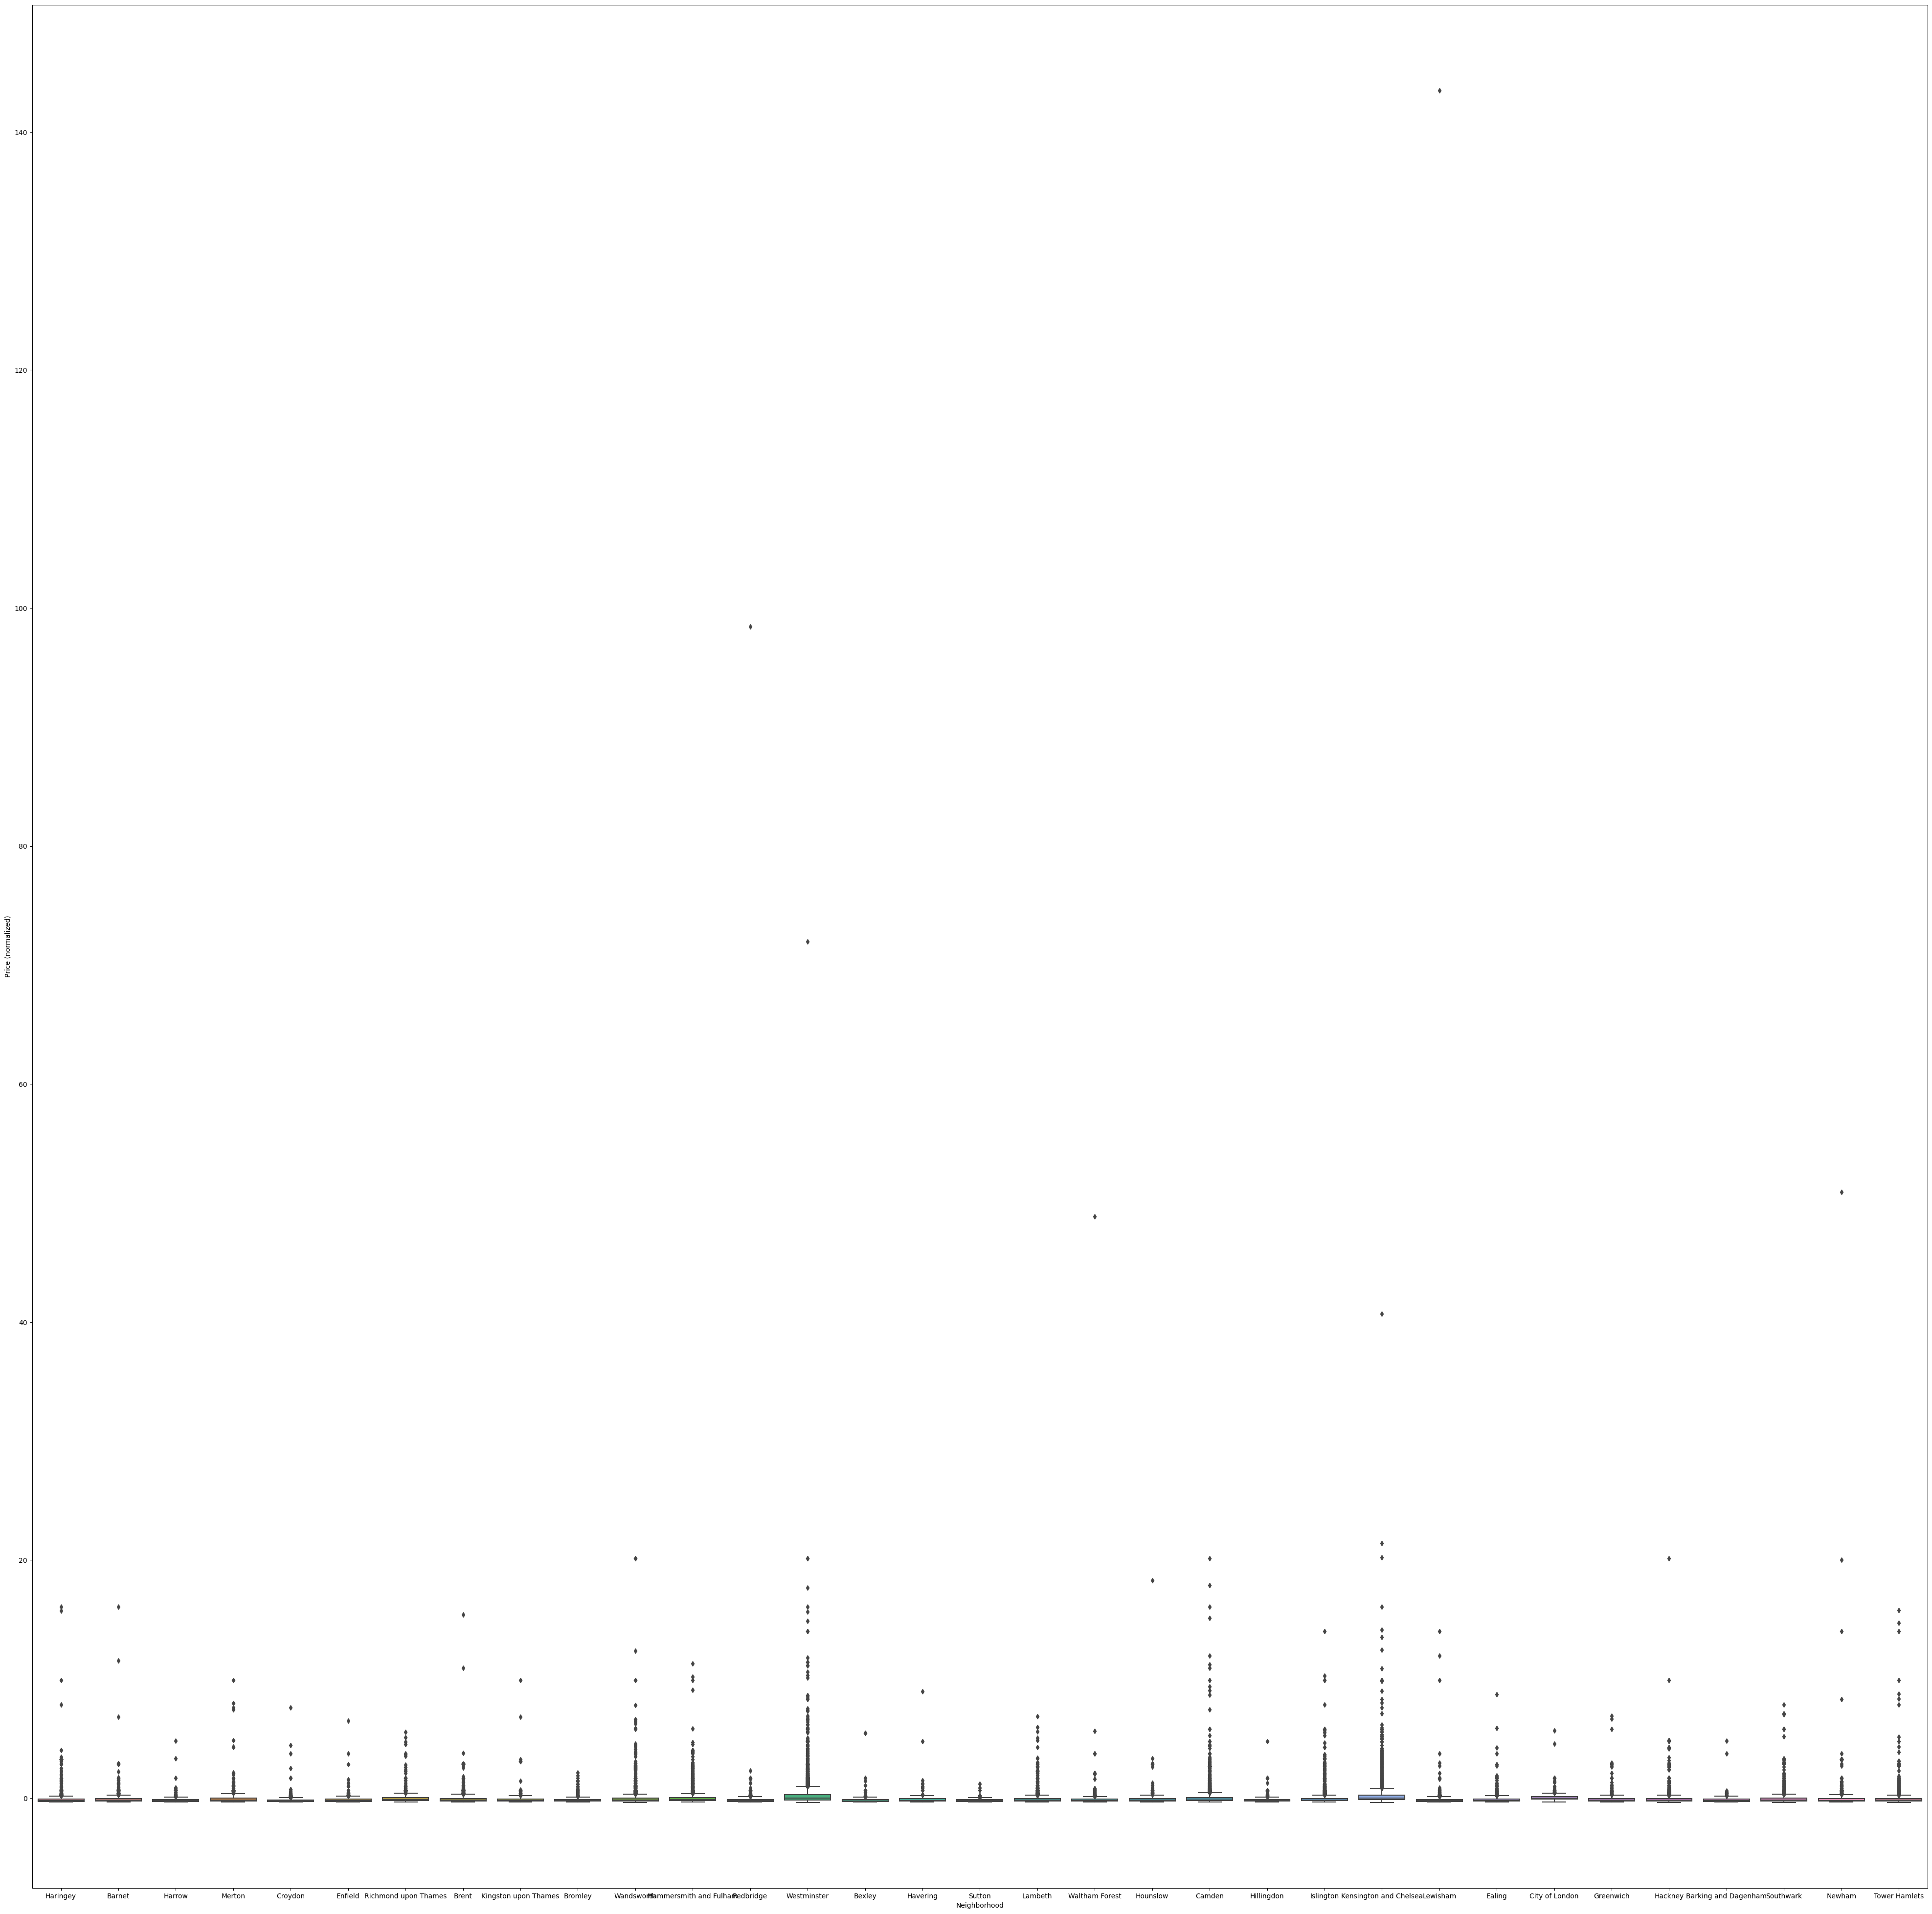

In [ ]:
# Boxplot of prices per Borough 

import matplotlib.pyplot as plt
import seaborn as sns


airbnb['price_normalized'] = (airbnb['price'] - airbnb['price'].mean()) / airbnb['price'].std()

#Create the boxplot
fig, ax = plt.subplots(figsize=(50, 50))
plt.suptitle('')
sns.boxplot(x='neighbourhood_cleansed', y='price_normalized', data=airbnb, ax=ax)
ax.set_xlabel('Neighborhood')
ax.set_ylabel('Price (normalized)')
plt.show()

**Correlation between prices & amenities**

In [80]:
#Correlation between price & amenities 

columns = ['private_bath', 'wifi', 'long_term_stays_allowed',
       'private_patio_or_balcony', 'private_entrance', 'pets_allowed',
       'outdoor_dining_area', 'lockbox', 'kitchen', 'hair_dryer',
       'free_street_parking', 'free_parking_on_premises',
       'dedicated_workspace', 'coffee_maker', 'coffee', 'bed_linens',
       'bathtub']


selected_columns = airbnb[columns]
corr = selected_columns.corrwith(airbnb["price"]).sort_values(ascending=False)

print(corr)


private_bath                0.109002
long_term_stays_allowed     0.067918
bed_linens                  0.058398
dedicated_workspace         0.050758
bathtub                     0.048218
private_entrance            0.034070
coffee_maker                0.031546
private_patio_or_balcony    0.020618
outdoor_dining_area         0.013222
coffee                      0.009601
pets_allowed                0.007603
kitchen                     0.000679
hair_dryer                 -0.006777
wifi                       -0.013208
lockbox                    -0.013438
free_street_parking        -0.030857
free_parking_on_premises   -0.033941
dtype: float64


**Correlation between Gastro & Prices**

In [102]:
#Correlation between price & gastro in 100 meters 

gastro_columns = ['bar_100', 'cafe_100', 'fast_food_100', 'restaurant_100']


selected_gastro_columns = poi_gastro[gastro_columns]
corr_g = selected_gastro_columns.corrwith(poi_gastro["price"]).sort_values(ascending=False)

print(corr_g)

restaurant_100    0.046425
bar_100           0.027084
cafe_100          0.024991
fast_food_100     0.023433
dtype: float64


In [104]:
#Correlation between price & gastro in 250 meters 

gastro_columns2 = ['bar_250', 'cafe_250', 'fast_food_250', 'restaurant_250']


selected_gastro_columns2 = poi_gastro[gastro_columns2]
corr_g2 = selected_gastro_columns2.corrwith(poi_gastro["price"]).sort_values(ascending=False)

print(corr_g2)

restaurant_250    0.058348
cafe_250          0.044482
bar_250           0.041279
fast_food_250     0.036031
dtype: float64


In [106]:
#Correlation between price & gastro in 500 meters 

gastro_columns5 = ['bar_500', 'cafe_500', 'fast_food_500', 'restaurant_500']


selected_gastro_columns5 = poi_gastro[gastro_columns5]
corr_g5 = selected_gastro_columns5.corrwith(poi_gastro["price"]).sort_values(ascending=False)

print(corr_g5)

restaurant_500    0.067721
cafe_500          0.062464
bar_500           0.054971
fast_food_500     0.042234
dtype: float64


## Calculation in Python

didnt work properly. still has to be checked

### POI in Area

In [ ]:
### subset's of df's for each amenity 
restaurant = osm_short[osm_short["amenity"] == "restaurant"][['id', 'latitude', 'longitude', 'name', 'amenity']]
fast_food = osm_short[osm_short["amenity"] == "fast_food"][['id', 'latitude', 'longitude', 'name', 'amenity']]
cafe = osm_short[osm_short["amenity"] == "cafe"][['id', 'latitude', 'longitude', 'name', 'amenity']]
bar = osm_short[osm_short["amenity"] == "bar"][['id', 'latitude', 'longitude', 'name', 'amenity']]
subway = osm_short[osm_short["railway"] == "subway_entrance"][['id', 'latitude', 'longitude', 'name', 'railway']]

street_test = osm_short[["id", "latitude", "longitude", "amenity"]]

In [ ]:
airbnb_short = airbnb[['id', 'latitude', 'longitude']]

#### Function meters_to_degrees

In [ ]:
# Define the conversion factor from meters to degrees based on the latitude
def meters_to_degrees(meters, latitude):
    proj_meters = pyproj.CRS("EPSG:3857")  # meters
    proj_latlon = pyproj.CRS("EPSG:4326")  # degrees
    transformer = pyproj.Transformer.from_crs(
        proj_meters, proj_latlon, always_xy=True)
    lon, lat = transformer.transform(meters, 0)

    # Calculate the distance per degree of latitude
    lat_dist_per_deg = 111132.954 - 559.822 * math.cos(2 * math.radians(latitude)) + 1.175 * math.cos(
        4 * math.radians(latitude)) - 0.0023 * math.cos(6 * math.radians(latitude))

    # Calculate the distance per degree of longitude
    lon_dist_per_deg = math.pi / 180 * 6378137 * \
        math.cos(math.radians(latitude))

    lat_degrees = meters / lat_dist_per_deg
    lon_degrees = meters / lon_dist_per_deg
    return lat_degrees, lon_degrees

### 100 Meter

In [ ]:
# ignore seetingswithcopy only for this cell. will be set back to warn at the end of the code
pd.options.mode.chained_assignment = None

# Convert the airbnb_short DataFrame to a GeoDataFrame with a Point geometry column
airbnb_geo = gpd.GeoDataFrame(airbnb_short, geometry=gpd.points_from_xy( airbnb_short["longitude"], airbnb_short["latitude"]))

# Convert the street_test DataFrame to a GeoDataFrame with a Point geometry column
street_test_geo = gpd.GeoDataFrame(street_test, geometry=gpd.points_from_xy(street_test["longitude"], street_test["latitude"]))

# Create an array of coordinates for the street_test GeoDataFrame
X = np.column_stack((street_test_geo["longitude"].values, street_test_geo["latitude"].values))

# Create a BallTree spatial index for the street_test GeoDataFrame
tree = BallTree(X, leaf_size=40)

# Define the radius of the search in meters
radius_meters = 100

# Loop through each row in airbnb_geo
for index, row in airbnb_geo.iterrows():
    # Convert the radius from meters to degrees based on the latitude
    lat, lon = row["latitude"], row["longitude"]
    lat_deg, lon_deg = meters_to_degrees(radius_meters, lat)

    # Use the BallTree spatial index to find the street_test rows within the search radius
    indices = tree.query_radius([[row["longitude"], row["latitude"]]], r=lon_deg)[0]

    # Filter the street_test rows to only those within the search radius
    candidate_rows = street_test_geo.iloc[indices]

    # Count the occurrences of each amenity in the candidate rows
    counts = candidate_rows["amenity"].value_counts().to_dict()

    # Add the counts as new columns in the airbnb_short DataFrame
    for amenity_type, count in counts.items():
        airbnb_short.at[index, amenity_type] = count

#    # Add the list of ids as a new column in the airbnb_short
#    airbnb_short.at[index, "street_test_ids"] = str(candidate_rows["id"].tolist())

    # If there are no amenities in the given radius, append "no amenities" in the list of ids
#    if not candidate_rows["id"].tolist():
#        airbnb_short.at[index, "street_test_ids"] = "no amenities"

    # Print progress
    if index % 10000 == 0:
        print(f"Processed {index} rows")

# Replace NaN values with 0
airbnb_short.fillna(value=0, inplace=True)

pd.options.mode.chained_assignment = 'warn'

Processed 0 rows
Processed 10000 rows
Processed 20000 rows
Processed 30000 rows
Processed 40000 rows
Processed 50000 rows
Processed 60000 rows
Processed 70000 rows


In [ ]:
airbnb_short.head(2)

,id,latitude,longitude,geometry,cafe,restaurant,bar,fast_food,bakery,food_court
0,714569379355913481,51.597280,-0.139330,POINT (-0.13933 51.59728),1.0,1.0,0.0,0.0,0.0,0.0
1,808038970516277767,51.636518,-0.177475,POINT (-0.17748 51.63652),0.0,0.0,0.0,0.0,0.0,0.0


### Nearest distance 

In [ ]:
### is calculating values, but they seem to small
from scipy.spatial import cKDTree

# Import the radians function from numpy
from numpy import radians

# Convert the latitude and longitude columns in both dataframes to radians
airbnb[['latitude', 'longitude']] = radians(airbnb[['latitude', 'longitude']])
subway[['latitude', 'longitude']] = radians(subway[['latitude', 'longitude']])

# Build the KDTree index using the radians converted latitude and longitude columns in the subway dataframe
subway_tree = cKDTree(subway[['latitude', 'longitude']])

# Query the KDTree index for the nearest subway station to each airbnb location
distances, indices = subway_tree.query(airbnb[['latitude', 'longitude']], k=1)

# Convert the distance from radians to meters
earth_radius = 6371000  # radius of the Earth in meters
distances_meters = distances * earth_radius

# Add the nearest subway station distance to each airbnb row
airbnb['nearest_subway_distance'] = distances_meters



In [ ]:
airbnb['nearest_subway_distance'].describe()

count    75241.000000
mean      2166.189912
std       2464.600486
min          4.702448
25%        618.154392
50%       1243.963159
75%       2764.208087
max      23286.218419
Name: nearest_subway_distance, dtype: float64

## Old

In [ ]:
# ### runs, but with too smal results 

# # ignore seetingswithcopy only for this cell. will be set back to warn at the end of the code 
# pd.options.mode.chained_assignment = None

# # Define the conversion factor from meters to degrees based on the latitude
# def meters_to_degrees(meters, latitude):
#     proj_meters = pyproj.CRS("EPSG:3857")  # meters
#     proj_latlon = pyproj.CRS("EPSG:4326")  # degrees
#     transformer = pyproj.Transformer.from_crs(proj_meters, proj_latlon, always_xy=True)
#     lon, lat = transformer.transform(meters, 0)
#     lat_dist_per_deg = 111132.954 - 559.822 * math.cos(2 * math.radians(latitude)) + 1.175 * math.cos(4 * math.radians(latitude))
#     lon_dist_per_deg = 111412.84 * math.cos(math.radians(latitude))
#     lat_degrees = meters / lat_dist_per_deg
#     lon_degrees = meters / lon_dist_per_deg
#     return lat_degrees, lon_degrees


# airbnb_test["closest_amenity"] = ""


# # Convert the airbnb_test DataFrame to a GeoDataFrame with a Point geometry column
# airbnb_test_geo = gpd.GeoDataFrame(airbnb_test, geometry=gpd.points_from_xy(airbnb_test["longitude"], airbnb_test["latitude"]))

# # Convert the street_test DataFrame to a GeoDataFrame with a Point geometry column
# street_test_geo = gpd.GeoDataFrame(street_test, geometry=gpd.points_from_xy(street_test["longitude"], street_test["latitude"]))

# # Create an R-tree spatial index for the street_test GeoDataFrame
# street_test_sindex = street_test_geo.sindex

# # Define the radius of the search in meters
# radius_meters = 1_000

# # Loop through each row in airbnb_test_geo
# for index, row in airbnb_test_geo.iterrows():
#     # Convert the radius from meters to degrees based on the latitude
#     lat, lon = row["latitude"], row["longitude"]
#     lat_deg, lon_deg = meters_to_degrees(radius_meters, lat)
    
#     # Use the R-tree spatial index to find the street_test rows within the search radius
#     candidate_indices = list(street_test_sindex.intersection(row.geometry.buffer(lon_deg).bounds))

#     # Filter the street_test rows to only those within the search radius
#     candidate_rows = street_test_geo.iloc[candidate_indices]
# #
#     if len(candidate_rows) == 0:
#         # No amenities within the search radius
#         closest_amenity_distance = np.nan
#     else:
#         # Calculate the distances from the current Airbnb location to all the amenities in the search radius
#         candidate_rows["distance"] = candidate_rows.geometry.distance(row.geometry)

#         # Sort the candidate rows by distance
#         candidate_rows = candidate_rows.sort_values("distance")

#         # Find the closest amenity and its distance
#         closest_amenity = candidate_rows["amenity"].iloc[0]
#         closest_amenity_distance = candidate_rows["distance"].iloc[0]

#     # Add the closest amenity and its distance as new columns in the airbnb_test DataFrame
#     airbnb_test.at[index, "closest_amenity"] = closest_amenity
#     airbnb_test.at[index, "closest_amenity_distance_m"] = closest_amenity_distance

#     # Print progress
#     if index % 10000 == 0:
#         print(f"Processed {index} rows")

# # set seetingswithcopy back only for this cell. will be set back to warn at the end of the code 
# pd.options.mode.chained_assignment = 'warn'


In [ ]:
#airbnb_test.describe()

In [ ]:
# ### runs, but with less accurate results, than in 4.1.

# ### Number of amenities + liste 

# import geopandas as gpd
# from shapely.geometry import Point
# from shapely.ops import transform
# from functools import partial
# import pyproj
# import math

# # Define the conversion factor from meters to degrees based on the latitude
# def meters_to_degrees(meters, latitude):
#     proj_meters = pyproj.CRS("EPSG:3857")  # meters
#     proj_latlon = pyproj.CRS("EPSG:4326")  # degrees
#     transformer = pyproj.Transformer.from_crs(
#         proj_meters, proj_latlon, always_xy=True)
#     lon, lat = transformer.transform(meters, 0)

#     # Calculate the distance per degree of latitude
#     lat_dist_per_deg = 111132.954 - 559.822 * math.cos(2 * math.radians(latitude)) + 1.175 * math.cos(
#         4 * math.radians(latitude)) - 0.0023 * math.cos(6 * math.radians(latitude))

#     # Calculate the distance per degree of longitude
#     lon_dist_per_deg = math.pi / 180 * 6378137 * \
#         math.cos(math.radians(latitude))

#     lat_degrees = meters / lat_dist_per_deg
#     lon_degrees = meters / lon_dist_per_deg
#     return lat_degrees, lon_degrees


# # Convert the airbnb_test DataFrame to a GeoDataFrame with a Point geometry column
# airbnb_test_geo = gpd.GeoDataFrame(airbnb_test, geometry=gpd.points_from_xy(airbnb_test["longitude"], airbnb_test["latitude"]))

# # Convert the street_test DataFrame to a GeoDataFrame with a Point geometry column
# street_test_geo = gpd.GeoDataFrame(street_test, geometry=gpd.points_from_xy(street_test["longitude"], street_test["latitude"]))

# # Create an R-tree spatial index for the street_test GeoDataFrame
# street_test_sindex = street_test_geo.sindex

# # Define the radius of the search in meters
# radius_meters = 200

# # Loop through each row in airbnb_test_geo
# for index, row in airbnb_test_geo.iterrows():
#     # Convert the radius from meters to degrees based on the latitude
#     lat, lon = row["latitude"], row["longitude"]
#     lat_deg, lon_deg = meters_to_degrees(radius_meters, lat)
    
#     # Use the R-tree spatial index to find the street_test rows within the search radius
#     candidate_indices = list(street_test_sindex.intersection(row.geometry.buffer(lon_deg).bounds))

#     # Filter the street_test rows to only those within the search radius
#     candidate_rows = street_test_geo.iloc[candidate_indices]

#     # Create an empty list to store the id's of street_test rows
#     ids = []

#     # Group the candidate rows by amenity and count the occurrences
#     counts = candidate_rows.groupby("amenity").size().to_dict()

#     # Add the counts as new columns in the airbnb_test DataFrame
#     for amenity_type, count in counts.items():
#         airbnb_test.at[index, amenity_type] = count
#         ids.extend(candidate_rows[candidate_rows["amenity"] == amenity_type]["id"].tolist())

#     # If there are no amenities in the given radius, append "no amenities" in the list of ids
#     if not ids:
#         ids.append("no amenities")
        
#     # Add the list of ids as a new column in the airbnb_test DataFrame
#     airbnb_test.at[index, "street_test_ids"] = str(ids)

#     # Print progress
#     if index % 10000 == 0:
#         print(f"Processed {index} rows")

# # Replace NaN values with 0
# airbnb_test.fillna(value=0, inplace=True)



In [ ]:
# ### Calculation of POI's in Area with Balltree (old, not working properly)

# # Calculate the needed radius when converted to unit sphere.
# distance_in_meter = 200
# earth_radius_in_meter = 6_371_000

# radius = distance_in_meter / earth_radius_in_meter

# # Convert the latitude and longitude columns to radians
# airbnb_test = airbnb_test.copy()
# airbnb_test.loc[:, 'lat_rad'] = np.radians(airbnb_test['latitude'])
# airbnb_test.loc[:, 'lon_rad'] = np.radians(airbnb_test['longitude'])
# street_test = street_test.copy()
# street_test.loc[:, 'lat_rad'] = np.radians(street_test['latitude'])
# street_test.loc[:, 'lon_rad'] = np.radians(street_test['longitude'])

# # Create a BallTree object with the latitude and longitude columns
# tree = BallTree(street_test[['lat_rad', 'lon_rad']],
#                 leaf_size=15, metric='haversine')

# # Find the indices of all neighbors within a radius of 500 meters
# # for each row in list_test
# indices = tree.query_radius(
#     airbnb_test[['lat_rad', 'lon_rad']], r=radius, count_only=False)

# # Calculate the number of neighbors for each amenity type
# amenity_types = street_test['amenity'].unique()
# amenity_counts = np.zeros((airbnb_test.shape[0], amenity_types.shape[0]))
# for i, amenity in enumerate(amenity_types):
#     street_indices = street_test[street_test['amenity'] == amenity].index
#     intersection_counts = np.array(
#         [np.intersect1d(street_indices, idx).size for idx in indices])
#     amenity_counts[:, i] = intersection_counts

# # Add the new columns to list_test
# list_test = pd.concat([airbnb_test, pd.DataFrame(amenity_counts, columns=[
#                       f'num_neighbors_{amenity}' for amenity in amenity_types])], axis=1)

# # Calculate the number of neighbors for each railway type
# railway_types = street_test['railway'].unique()
# railway_counts = np.zeros((list_test.shape[0], railway_types.shape[0]))
# for i, railway in enumerate(railway_types):
#     street_indices = street_test[street_test['railway'] == railway].index
#     intersection_counts = np.array(
#         [np.intersect1d(street_indices, idx).size for idx in indices])
#     railway_counts[:, i] = intersection_counts

# # Add the new columns to list_test
# list_test = pd.concat([list_test, pd.DataFrame(railway_counts, columns=[
#                       f'num_neighbors_{railway}' for railway in railway_types])], axis=1)


# # Remove the temporary columns
# list_test.drop(columns=['lat_rad', 'lon_rad'], inplace=True)
# street_test.drop(columns=['lat_rad', 'lon_rad'], inplace=True)


### Nearest Station-old

In [ ]:
# from haversine import haversine, Unit

# # define a function to calculate distance between two points
# def calc_distance(lat1, lon1, lat2, lon2):
#     return haversine((lat1, lon1), (lat2, lon2), unit=Unit.METERS)

# # get all unique values in "tags.railway" that are present in airbnb
# railway_tags = airbnb["railway"].unique()

# # loop through each row in airbnb and calculate the minimum distance
# # for each value in airbnb["railway"]
# for tag in railway_tags:
#     distances = []
#     for _, row in airbnb[airbnb["railway"] == tag].iterrows():
#         min_distance = None
#         for _, sm_row in osm_short[osm_short["railway"] == tag].iterrows():
#             distance = calc_distance(row["latitude"], row["longitude"], sm_row["latitude"], sm_row["longitude"])
#             if min_distance is None or distance < min_distance:
#                 min_distance = distance
#         distances.append(min_distance)

#     # add the calculated minimum distances as a new column in airbnb
#     col_name = "min_distance_{}".format(tag)
#     airbnb.loc[airbnb["railway"] == tag, col_name] = distances


In [ ]:
from haversine import haversine, Unit

# define a function to calculate distance between two points
def calc_distance(lat1, lon1, lat2, lon2):
    return haversine((lat1, lon1), (lat2, lon2), unit=Unit.METERS)

# only one value in "tags.railway", so use it directly in the loop
tag = "restaurant"

distances = []
for _, row in airbnb.iterrows():
    min_distance = None
    for _, sm_row in osm_short[osm_short["amenity"] == tag].iterrows():
        distance = calc_distance(row["latitude"], row["longitude"], sm_row["latitude"], sm_row["longitude"])
        if min_distance is None or distance < min_distance:
            min_distance = distance
    distances.append(min_distance)

# add the calculated minimum distances as a new column in airbnb
col_name = "min_distance_{}".format(tag)
airbnb[col_name] = distances


KeyboardInterrupt: 